In [3]:
from gurobipy import GRB, Model, quicksum
import networkx as nx
import matplotlib.pyplot as plt
import random

# Create Data

In [4]:
# Number warehouses
num_w = 3
# Number customers
num_c = 10

Central warehouses (1. Layer)

In [5]:
W = [f'W{i}' for i in range(num_w)]

Regional warehouses (2. Layer)

In [6]:
R = [f'R{i}' for i in range(2*num_w)]

Customers (3. Layer)

In [7]:
C = [f'C{i}' for i in range(num_c)]

Create edges

In [9]:
edges = []

# from central to regional warehouse
for w in W:
    for r in R:
        edges.append((w, r))
        
# from regional warehouse to customer
for r in R:
    for c in C:
        edges.append((r, c))

Create graph

In [11]:
G = nx.DiGraph(edges)

In [12]:
node_color = []

for n in G.nodes:
    if n[0] == 'W':
        node_color.append('r')
    if n[0] == 'R':
        node_color.append('g')
    if n[0] == 'C':
        node_color.append('y')

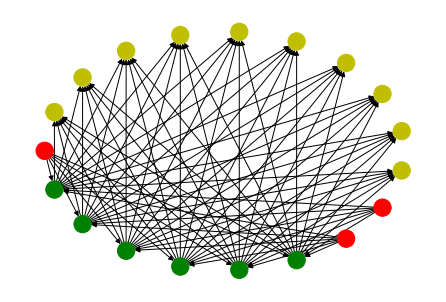

In [13]:
nx.draw_shell(G, node_color=node_color)

In [14]:
random.seed(73)
dem = {c: random.randint(50, 100) for c in C}
cost = {e: random.randint(1, 10) for e in G.edges}
dem_tot = sum(dem.values())
# Distribute total demand equally among all cetral warehouses
sup = {w: int((dem_tot+(3-dem_tot%3))/3) for w in W}

# Optimization Model

In [15]:
m = Model()

Decision variables

In [16]:
twr = m.addVars(W, R)
trc = m.addVars(R, C)
y = m.addVars(R, vtype=GRB.BINARY)

Constraints

In [17]:
# Satisfy demand
m.addConstrs(dem[c] == quicksum(trc[r, c] for r in R) for c in C)
# Respect supply
m.addConstrs(sup[w] >= quicksum(twr[w, r] for r in R) for w in W)
# Flow equation
m.addConstrs(quicksum(twr[w, r] for w in W) == quicksum(trc[r, c] for c in C) 
             for r in R)
# Big M
M = sum(dem.values())
m.addConstrs(quicksum(twr[w, r] for w in W) <= M*y[r] for r in R)
m.update()

First objective: Minimize total transportation costs

In [18]:
t_cost_total = m.addVar()
m.addConstr(
    t_cost_total == 
    quicksum(cost[w, r] * twr[w, r] for w in W for r in R) + 
    quicksum(cost[r, c] * trc[r, c] for r in R for c in C)
)
m.update()

Second objective: Minimize total number of used regional warehouses

In [19]:
y_total = m.addVar()
m.addConstr(y_total == quicksum(y[r]for r in R))
m.update()

In [20]:
m.setObjective(
    t_cost_total, sense=GRB.MINIMIZE
)

In [21]:
results = []

for i in range(len(R), 0, -1):
    m.addConstr(y_total <= i)
    m.optimize()
    results.append((y_total.X, m.ObjVal))

Gurobi Optimizer version 9.0.3 build v9.0.3rc0 (win64)
Optimize a model with 28 rows, 86 columns and 267 nonzeros
Model fingerprint: 0x77691619
Variable types: 80 continuous, 6 integer (6 binary)
Coefficient statistics:
  Matrix range     [1e+00, 7e+02]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e+00, 2e+02]
Presolve removed 9 rows and 8 columns
Presolve time: 0.01s
Presolved: 19 rows, 78 columns, 156 nonzeros
Variable types: 78 continuous, 0 integer (0 binary)

Root relaxation: objective 3.799000e+03, 17 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    3799.0000000 3799.00000  0.00%     -    0s

Explored 0 nodes (17 simplex iterations) in 0.02 seconds
Thread count was 16 (of 16 available processors)

Solution count 1: 3799 

Optimal solution found (tolerance 1.00e-04)
Best objective

In [23]:
results

[(6.0, 3799.0),
 (4.0, 3799.0),
 (4.0, 3799.0),
 (3.0, 3828.0),
 (2.0, 4927.0),
 (1.0, 7196.0)]

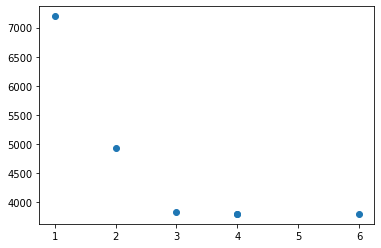

In [21]:
x = [e[0] for e in results]
y = [e[1] for e in results]

plt.scatter(x, y)
plt.show()